In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import Sim
from mdetsims.cs_interp import interpolate_image_and_noise_cs
from mdetsims.interp import interpolate_image_and_noise
from mdetsims.masking import generate_bad_columns, generate_cosmic_rays
from mdetsims.symmetrize import symmetrize_bad_mask

In [3]:
rng = np.random.RandomState()

sim = Sim(
    rng=rng,
    g1=0.02,
    gal_type='wldeblend',
    scale=0.263,
    psf_type='wldeblend',
    n_coadd=10,
    gal_kws={'survey_name': 'DES', 'bands': ['r', 'i', 'z']})

mbobs = sim.get_mbobs()

# here we make the mask
bad_mask = np.zeros(mbobs[0][0].image.shape, dtype=np.bool)
bad_mask |= generate_bad_columns(
    mbobs[0][0].image.shape, rng=rng, mean_bad_cols=10)
bad_mask |= generate_cosmic_rays(
    mbobs[0][0].image.shape, rng=rng, mean_cosmic_rays=10)

# applies a 90 degree rotation to make it symmetric
symmetrize_bad_mask(bad_mask)

(0.0, 1.0, 0.0, 1.0)

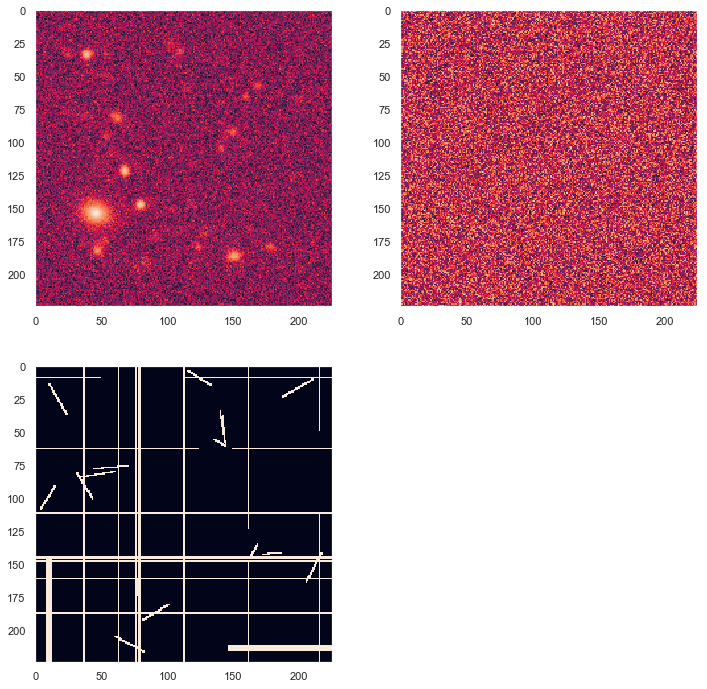

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].imshow(np.arcsinh(mbobs[0][0].image/np.std(mbobs[0][0].noise)))
axs[0, 0].grid(False)

axs[0, 1].imshow(np.arcsinh(mbobs[0][0].noise/np.std(mbobs[0][0].noise)))
axs[0, 1].grid(False)

axs[1, 0].imshow(np.arcsinh(bad_mask.astype(int)))
axs[1, 0].grid(False)

axs[1, 1].axis('off')

In [31]:
%%time

interp_img, interp_nse = interpolate_image_and_noise_cs(
    image=mbobs[0][0].image,
    noise=mbobs[0][0].noise,
    bad_mask=bad_mask,
    rng=rng,
    sampling_rate=1,
    c=50)

CPU times: user 815 ms, sys: 17.9 ms, total: 833 ms
Wall time: 843 ms


In [32]:
%%time

interp_img_cb, interp_nse_cb = interpolate_image_and_noise(
    image=mbobs[0][0].image, 
    noise=mbobs[0][0].noise, 
    bad_mask=bad_mask, 
    rng=rng)

CPU times: user 1.6 s, sys: 245 ms, total: 1.84 s
Wall time: 1.49 s


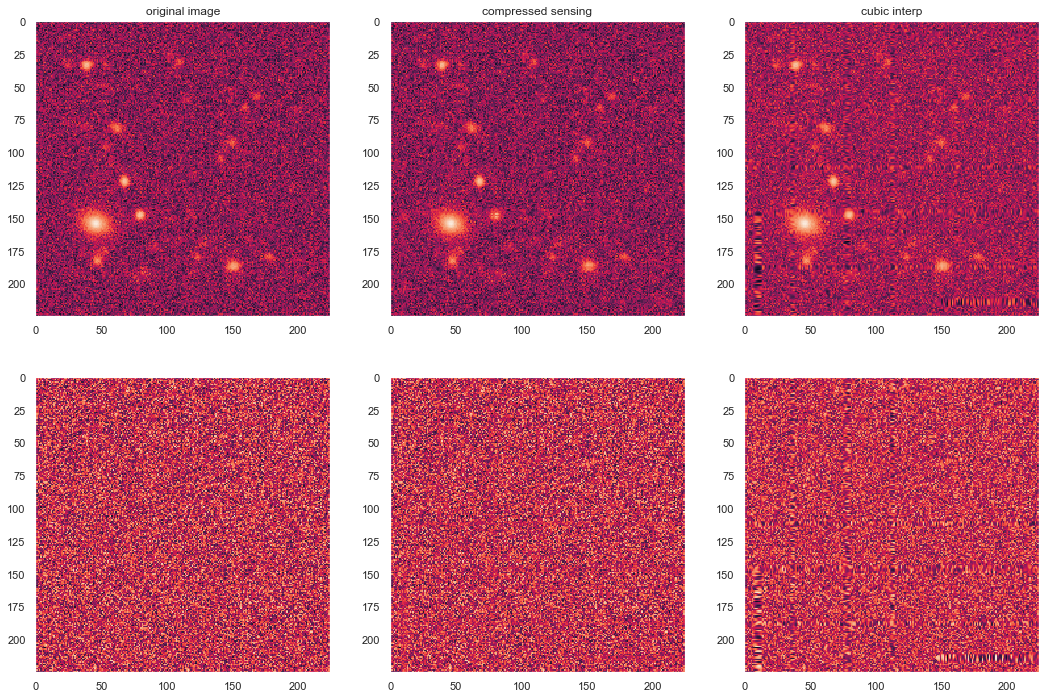

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

scl = np.std(mbobs[0][0].noise)

axs[0, 0].imshow(np.arcsinh(mbobs[0][0].image/scl))
axs[0, 0].grid(False)
axs[0, 0].set_title('original image')

axs[0, 1].imshow(np.arcsinh(interp_img/scl))
axs[0, 1].grid(False)
axs[0, 1].set_title('compressed sensing')

axs[0, 2].imshow(np.arcsinh(interp_img_cb/scl))
axs[0, 2].grid(False)
axs[0, 2].set_title('cubic interp')

axs[1, 0].imshow(np.arcsinh(mbobs[0][0].noise/scl))
axs[1, 0].grid(False)

axs[1, 1].imshow(np.arcsinh(interp_nse/scl))
axs[1, 1].grid(False)

axs[1, 2].imshow(np.arcsinh(interp_nse_cb/scl))
axs[1, 2].grid(False)